# Internet Data Analysis 

Data source: The CAIDA UCSD ITDK - 26 Sept 2024 - Present, https://catalog.caida.org/dataset/ark_itdk

*Publication notification submitted to CAIDA on 26 Sept 2024 via [this form](https://www.caida.org/catalog/datasets/publications/report-publication/) as [instructed](https://www.caida.org/about/legal/aua/public_aua/)*

I had this (in hindsight, very weak) idea that I could
 - smash out an iPhone app that traces routes to a number of Internet service providers, content delivery networks and large organizations,
 - convince a number of people to download the app (ideally traveling with it running in the background), 
 - to assemble a semi-interesting albeit sparse dataset, 
 - that once cleaned and analyzed, would help me understand how data is moved on the modern Internet

Fortunately, actual professionals have been doing this for decades and have figured out how to overcome the myriad problems associated with inferring network relationships and attribution through probing. 

Internet Routing Datasets from [CAIDA](https://www.caida.org/). 

> Founded in 1997, the Center for Applied Internet Data Analysis (CAIDA) conducts network research and builds research infrastructure to support large-scale data collection, curation, and data distribution to the scientific research community. CAIDA is based at the San Diego Supercomputer Center, located on the UC San Diego campus in La Jolla, CA.

CAIDA hosts [a range of interesting datasets](https://www.caida.org/catalog/datasets/overview/) related to their work analyzing Internet architecture and routing. 

I'll explore the illustrious Internet Topology Data Kit (ITDK) in this notebook. This data resulted from studying Internet routes at the *router* level. We need to understand the following things about the dataset: 
 - Interface: A physical or virtual connection used by a connected device to move traffic
 - Nodes: These are routing devices on the internet which have one or more *interfaces*. Note the collocation of these interfaces is *inferred*
 - Links: These are the **IP** connections which are inferred to be shared by two interfaces (and hence nodes), note depending on how layer 2 switching is done, these can be shared by different interfaces or nodes
 - Location: The inferred location of the *node* based on the publically available MaxMind database (also a cool dataset, albeit one behind an API) 

Steps: 
1. [Register and gain access to](https://catalog.caida.org/dataset/ark_itdk) either the restricted or the public dataset. 
2. Once through the registration wall, find the year/mont ITDK you'd like to analyze. The ITDK datasets are located in the `ark/ipv4/itdk` path. E.g. https://publicdata.caida.org/datasets/topology/ark/ipv4/itdk/2023-03/
3. Read [this](https://catalog.caida.org/recipe/parse_the_itdk) absolutely epic quickstart and sample code for parsing the dataset.
4.

In [1]:
!ls ../2023-03

README.txt                          midar-iff.ifaces.bz2
itdk-run-20220224-dns-names.txt.bz2 midar-iff.links.bz2
itdk-run-20230308-dns-names.txt.bz2 midar-iff.nodes.as.bz2
itdk-run-20230308.addrs.bz2         midar-iff.nodes.bz2
itdk-run-20230315-dns-names.txt.bz2 midar-iff.nodes.geo.bz2
itdk-run-20230315.addrs.bz2         speedtrap.links.bz2
midar-iff.geo-re.jsonl.txt          speedtrap.nodes.bz2


Run the script to validate the parsing and extract an AS entry:

```
itdk % python parse_itdk.py -a 2023-03/midar-iff.nodes.as.bz2 -l 2023-03/midar-iff.links.bz2 -n 2023-03/midar-iff.nodes.bz2 -g 2023-03/midar-iff.nodes.geo.bz2 -p 3356
Parsing Nodes AS File...
Parsing Links File...
Parsing Nodes File...
Parsing Nodes Geolocation File...
Number of Nodes found: 63316
{'asn': '3356', 'links': {'19551'}, 'interfaces': set(), 'continent': 'NA', 'country': 'US', 'region': 'PA', 'city': '39.9544', 'latitude': '-75.1657', 'longitude': 'maxmind'}
```

TO DO : 
- suggest some interesting views on the data
- use networkx package to visualize some or all of the relationships 
- use geopandas to plot the AS locations and links if possible
- attempt to animate the graph to display a dimension of the information that isn't easily portrayed in a static image... obvious one being actual temporal information which is absent from the ITDK, but is present in the ARK data
    - tutorial on animating: https://www.kaggle.com/code/kennethgranahan/plot-animate-statistical-data-with-geopandas

In [28]:
import pandas as pd

In [2]:
# ITDK location, only used if we haven't created an intermediate representation in parquet already
itdk_dir = "../2023-03"

# The transcoded and much more speedy version of the ITDK data we care about
as_file='./2023_itdk_as.parquet' 
node_file='./2023_itdk_nodes.parquet'

# Load

Rework of code supplied in https://catalog.caida.org/assets/recipe/parse_the_itdk/parse_itdk.py, note license which applies to derivative products (this whole cell). 

In [3]:
# Copyright (c) 2020 The Regents of the University of California
# All Rights Reserved

#!  /usr/bin/env python3
__author__ = "Donald Wolfson"
__email__ = "dwolfson@zeus.caida.org"
# This software is Copyright (C) 2020 The Regents of the University of
# California. All Rights Reserved. Permission to copy, modify, and
# distribute this software and its documentation for educational, research
# and non-profit purposes, without fee, and without a written agreement is
# hereby granted, provided that the above copyright notice, this paragraph
# and the following three paragraphs appear in all copies. Permission to
# make commercial use of this software may be obtained by contacting:
#
# Office of Innovation and Commercialization
#
# 9500 Gilman Drive, Mail Code 0910
#
# University of California
#
# La Jolla, CA 92093-0910
#
# (858) 534-5815
#
# invent@ucsd.edu
#
# This software program and documentation are copyrighted by The Regents of
# the University of California. The software program and documentation are
# supplied â€œas isâ€, without any accompanying services from The Regents. The
# Regents does not warrant that the operation of the program will be
# uninterrupted or error-free. The end-user understands that the program
# was developed for research purposes and is advised not to rely
# exclusively on the program for any reason.
#
# IN NO EVENT SHALL THE UNIVERSITY OF CALIFORNIA BE LIABLE TO ANY PARTY FOR
# DIRECT, INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES,
# INCLUDING LOST PR OFITS, ARISING OUT OF THE USE OF THIS SOFTWARE AND ITS
# DOCUMENTATION, EVEN IF THE UNIVERSITY OF CALIFORNIA HAS BEEN ADVISED OF
# THE POSSIBILITY OF SUCH DAMAGE. THE UNIVERSITY OF CALIFORNIA SPECIFICALLY
# DISCLAIMS ANY WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE
# SOFTWARE PROVIDED HEREUNDER IS ON AN â€œAS ISâ€ BASIS, AND THE UNIVERSITY OF
# CALIFORNIA HAS NO OBLIGATIONS TO PROVIDE MAINTENANCE, SUPPORT, UPDATES,
# ENHANCEMENTS, OR MODIFICATIONS.

################################## Imports #####################################

import argparse
import sys
import json
import bz2
import re
import pandas as pd

############################## Global Variables ################################

# Datasets
as_2_data = {}                  # Maps an asn to all of its ITDK data found.
"""
{
    "asn" : {
        "asn" : "...",
        "links" : set(),
        "interfaces" : set(),
        "continent" : "...",
        "country" : "...",
        "region" : "...",
        "city" : "...",
        "latitude" : "...",
        "longitude" : "..."
    }
}
"""
node_id_2_asn = {}            # Maps a node_id to its corresponding asn.
ases_2_print = None           # A list of asns to print to STDOUT.

# Definitions
re_txt = re.compile(r".txt$")
re_bz2 = re.compile(r".bz2$")

# File Paths
links_file = None
nodes_file = None
nodes_geo_file = None
nodes_as_file = None

############################### Helper Methods #################################

def print_help():
    print(sys.argv[0], "-a nodes.as_file.bz2 -l links_file.bz2 -n nodes_file.bz2 -g nodes_geo_file.bz2", file=sys.stderr)
    sys.exit()


# Opens the nodes_as_file and sends each line to a helper method.
def parse_nodes_as_file():
    global re_txt
    global re_bz2
    global nodes_as_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(nodes_as_file):
        with bz2.open(nodes_as_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_nodes_as_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(nodes_as_file):
        with open(nodes_as_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_nodes_as_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Parses a given line of the nodes_as_file and updates as_2_data.
def parse_nodes_as_body(curr_line):
    global node_id_2_asn

    # Edge Case: Skip any commented lines.
    if curr_line[0] == "#":
        return

    # Format of curr_line: "node.AS   <node_id>   <AS>   <method>"
    ignore, node_id, asn, method = curr_line.split()

    # Map the node_id to its corresponding asn.
    node_id_2_asn[node_id] = asn


# Opens the links_file and sends each line to a helper method.
def parse_links_file():
    global re_txt
    global re_bz2
    global links_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(links_file):
        with bz2.open(links_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_links_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(links_file):
        with open(links_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_links_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Given a string of a line from a Links File, update as_2_data.
def parse_links_body(curr_line):
    global as_2_data
    global node_id_2_asn

    # Edge Case: Skip any commented lines.
    if curr_line[0] == "#":
        return

    # Format of curr_line: "link <link_id>: <N1>:i1 <N2>:i2 [ <N3>:[i3] ... ]"
    curr_line = curr_line.split()
    
    # Skip any lines that don't have any data.
    if len(curr_line) < 4:
        return

    # Format of curr_line: [ "link", link_id, [ N1, Interface ], N2, ... ]
    curr_line[2] = curr_line[2].split(":")
    node_id = curr_line[2][0]
    
    # Edge Case: Skip this line if the node_id doesn'st map to an asn.
    if node_id in node_id_2_asn:
        asn = node_id_2_asn[curr_line[2][0]]
    else:
        return
    
    # Create the current asn's object.
    as_2_data[asn] = {
        "asn" : asn,
        "links" : set(),
        "interfaces" : set(),
        "continent" : None,
        "country" : None,
        "region" : None,
        "city" : None,
        "latitude" : None,
        "longitude" : None
    }

    # Add the current interface if it exists.
    if len(curr_line[2]) == 2:
        interface = curr_line[2][1]
        as_2_data[asn]["interfaces"].add(interface)

    # Iterate over N2 to Nm and add all asns to the current link interface.
    for node in curr_line[3:]:
        # Split the node_id from the interface.
        node_data = node.split(":")
        node_id = node_data[0]
        
        # Add the link between the asn and node if the node has a mappable asn.
        if node_id in node_id_2_asn:
            curr_asn = node_id_2_asn[node_id]

            # Add the current asn to the parent asn's links set.
            as_2_data[asn]["links"].add(curr_asn)


# Opens the links_file and sends each line to a helper method.
def parse_nodes_file():
    global re_txt
    global re_bz2
    global nodes_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(nodes_file):
        with bz2.open(nodes_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_links_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(nodes_file):
        with open(nodes_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_links_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given.
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Parses a given line of the nodes_file and updates as_2_data.
def parse_nodes_body(curr_line):
    global as_2_data
    global node_id_2_asn
    
    # Edge Case: Skip any commented lines. 
    if curr_line == "#":
        return

    # Format of curr_line: "node <node_id>: <i1> <i2> ... <in>"
    curr_line = curr_line.split()
    # Format of curr_line: [ "node", "<node_id>:", "<i1>", "<i2>", ..., "<in>" ]
    node_id = curr_line[2].replace(":","")

    # Skip line if node_id isn't mappable to an asn.
    if node_id not in node_id_2_asn:
        return

    asn = node_id_2_asn[node_id]

    # Skip line if asn not in as_2_data.
    if asn not in as_2_data:
        return

    # Iterate over interfaces on the current line, and add them to as_2_data.
    for interface in curr_line[2:]:
        as_2_data[asn]["interfaces"].add(interface)


# Opens the nodes_geo_file and sends each line to a helper method.
def parse_nodes_geo_file():
    global re_txt
    global re_bz2
    global nodes_geo_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(nodes_geo_file):
        with bz2.open(nodes_geo_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_nodes_geo_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(nodes_geo_file):
        with open(nodes_geo_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_nodes_geo_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Parses a given line of the nodes_geo_file and updates as_2_data.
def parse_nodes_geo_body(curr_line):
    global as_2_data
    global node_id_2_asn

    # Edge Case: Skip any commented lines. 
    if curr_line == "#":
        return
    
    curr_line = curr_line.split()
    node_id = curr_line[1].replace(":","")

    # Skip line if node_id isn't mappable to an asn.
    if node_id not in node_id_2_asn:
        return

    asn = node_id_2_asn[node_id]

    # Skip line if asn not in as_2_data.
    if asn not in as_2_data:
        return

    # Depending on length of curr_line update data with what is given.
    if len(curr_line) == 8:
        as_2_data[asn]["continent"] = curr_line[2]
        as_2_data[asn]["country"] = curr_line[3]
        as_2_data[asn]["region"] = curr_line[4]
        as_2_data[asn]["city"] = curr_line[5]
        as_2_data[asn]["latitude"] = curr_line[6]
        as_2_data[asn]["longitude"] = curr_line[7]
    elif len(curr_line) == 5:
        as_2_data[asn]["latitude"] = curr_line[2]
        as_2_data[asn]["longitude"] = curr_line[3]

# Print a given asn to STDOUT.
def get_as_data(asn):
    global as_2_data
    
    # Edge Case: Print error if asn not in as_2_data.
    if asn not in as_2_data:
        print("{} not in as_2_data".format(asn))
    else:
        print(as_2_data[asn])
def load_itdk(itdk_base): 
    global as_2_data
    global node_id_2_asn
    global ases_2_print
    global re_txt
    global re_bz2
    global links_file
    global nodes_file
    global nodes_geo_file
    global nodes_as_file
    
    nodes_file = f"{itdk_base}/midar-iff.nodes.bz2" 
    links_file = f"{itdk_base}/midar-iff.links.bz2"
    nodes_geo_file = f"{itdk_base}/midar-iff.nodes.geo.bz2"
    nodes_as_file = f"{itdk_base}/midar-iff.nodes.as.bz2"
    
    # Update node_id_2_asn with data from Nodes AS file.
    print("Parsing Nodes AS File...", file=sys.stderr)
    parse_nodes_as_file()
    
    # Update as_2_data with each asn's links.
    print("Parsing Links File...", file=sys.stderr)
    parse_links_file()
    
    # Update as_2_data with each asn's interfaces.
    print("Parsing Nodes File...", file=sys.stderr)
    parse_nodes_file()
    
    # Update as_2_data with each asn's geolocation.
    print("Parsing Nodes Geolocation File...", file=sys.stderr)
    parse_nodes_geo_file()
    
    print("Number of Nodes found: {}".format(len(as_2_data)), file=sys.stderr)

    df_as = pd.DataFrame.from_dict(data=as_2_data, orient='index') 
    df_node = pd.DataFrame.from_dict(data=node_id_2_asn, orient='index') 
    
    return df_as, df_node

🐢 The parsing operation is quite time consuming. Use an intermediate format (df serialized into a parquet file) if we've already load it and squirrelled it away, otherwise abide the lengthy parse operation, get the two table into a dataframe and write out to expedite the next go-around. 

In [4]:
df_as = None
df_node = None 

try: 
    df_as = pd.read_parquet(path=node_file) 
    df_node = pd.read_parquet(path=as_file) 
    
except FileNotFoundError: 
    df_as, df_node = load_itdk(itdk_dir)
    
    df_node.to_parquet(path=node_file)
    df_as.to_parquet(path=as_file)

Parsing Nodes AS File...
Parsing Links File...
Parsing Nodes File...
Parsing Nodes Geolocation File...
Number of Nodes found: 63316


# Explore 

In [17]:
df_as.head()

,asn,links,interfaces,continent,country,region,city,latitude,longitude
11061,11061,{11061},{},None,None,None,None,None,None
8585,8585,{8585},{},None,None,None,None,None,None
134771,134771,{134771},{},None,None,None,None,None,None
23969,23969,{23969},{},None,None,None,None,None,None
131293,131293,{131293},{},None,None,None,None,None,None


In [18]:
df_as.count()

asn           63316
links         63316
interfaces    63316
continent      5323
country        5323
region         5323
city           5323
latitude       5323
longitude      5323
dtype: int64

In [19]:
len(df_as['asn'].unique())

63316

In [32]:
df_as['links'].count()

np.int64(63316)

In [40]:
def count(s): 
    return(len(s))

df_as['link_count'] = df_as['links'].apply(count)
df_as['interface_count'] = df_as['interfaces'].apply(count)

In [84]:
df_as[df_as['link_count']>2].head()

,asn,links,interfaces,continent,country,region,city,latitude,longitude,link_count,interface_count
269663,269663,"{1916, 37721, 6939, 262589}",{187.16.222.12},None,None,None,None,None,None,4,1
266298,266298,"{1916, 6939, 262589}",{45.6.54.52},None,None,None,None,None,None,3,1
52639,52639,"{263237, 22548, 37721, 6939}",{187.16.217.169},None,None,None,None,None,None,4,1
271330,271330,"{1916, 37721, 6939, 262589}",{187.16.214.10},None,None,None,None,None,None,4,1
55542,55542,"{6939, 4648, 7575}",{218.100.53.45},None,None,None,None,None,None,3,1


In [71]:
df_as_geo = df_as[df_as['link_count']>1]

In [72]:
df_as_geo.count()

asn                1143
links              1143
interfaces         1143
continent            40
country              40
region               40
city                 40
latitude             40
longitude            40
link_count         1143
interface_count    1143
dtype: int64

In [55]:
import matplotlib.pyplot as plt

In [73]:
import networkx as nx
G = nx.Graph()

In [74]:
G.add_nodes_from(df_as_geo['asn'])

In [100]:
for index, row in df_as_geo[['asn','links']].head().iterrows(): 
    print(index)
    print(row['asn']) 

202317
202317
33674
33674
1975
1975
46964
46964
395104
395104


In [102]:
for index, row in df_as_geo[['asn', 'links']].iterrows(): 
    for link in row['links']: 
        G.add_edge(row['asn'], link)

In [103]:
G.number_of_nodes()

1904

In [104]:
G.number_of_edges()

2678

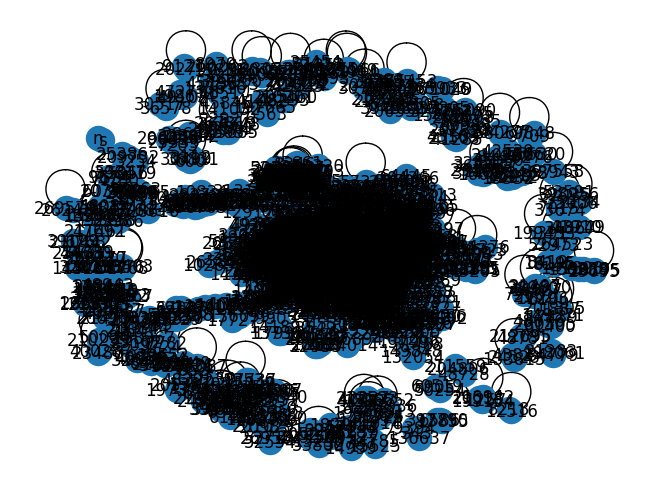

In [105]:
nx.draw(G, with_labels=True)